In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from timeit import default_timer as timer
import tensorflow as tf
from tensorflow.python.client import device_lib


Using TensorFlow backend.


In [2]:
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
print(device_lib.list_local_devices())




config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 4} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)
print("----------------------------")
print
print(device_lib.list_local_devices())



[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2244782376424479140
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11275639194
locality {
  bus_id: 1
}
incarnation: 18186904832363693135
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]
----------------------------

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2984573572763541353
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 355336192
locality {
  bus_id: 1
}
incarnation: 5393659707789050323
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


# TODO:
* Record trials in an organized excel sheet, or write out each one to a .txt file 
* 


## Generate sine wave data points

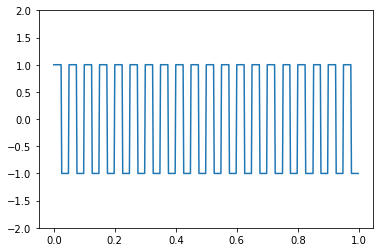

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
500


In [30]:
#Define characteristics of the data to generate
num_cycles = 20
sample_rate = 0.1

#points_per_cycle = int((2*np.pi) / sample_rate)

#Sample from a pure sine wave
#data = [np.sin(i) for i in np.arange(start=0, stop=num_cycles*2*np.pi, step=sample_rate)]

#print("Total data points: " + str(len(data)))

#Get the number of points for a clean multiple of some batch size
# print(int(len(data)/4))
# print(int(len(data)/4) * 4)
#batch_size = 4



from scipy import signal
import matplotlib.pyplot as plt
import numpy as np


num_waves = 20


t = np.linspace(0, 1, 500, endpoint=False)
data = signal.square(2 * np.pi * num_waves * t)

points_per_cycle = 25

plt.plot(t, data)
plt.ylim(-2, 2)
plt.show()


print(data[0:10])
print(len(data))



In [31]:
# df = dataframe.drop('time', 1)


# #Store as a numpy ndarray
# data = df.values
# data = data.astype('float32')


# #div_variable = 2



# #Take second half of the data
# #data_index = int(len(data)/div_variable)



# data = data[-int(len(data)/2):]
# #Undersample
# data = data[0::50]
# print("final data length: " + str(len(data)))


# num_cycles = int(47/2)
# print("num_cycles: " + str(num_cycles))

# points_per_cycle = int(len(data)/num_cycles)
# print("Points per cycle: " + str(points_per_cycle))







## Data Formatting
* `series_to_examples`: Function to convert a 1D series into example data consisting of `X` and `Y` columns
* `prepare_data`: Function to prepare and split data into `train`/`test` sets

* NOTE: We can also add scaling in these functions, to squash values closer together


In [32]:
# Convert 1D series into example data of X and Y columns
def series_to_examples(series, n_prev=1, n_forecast=1, dropnan=True):
    """
    Transform time series data into supervised learning dataset.
    Arguments: 
        series: Sequence of observations as a list
        n_prev: Number of lag observations as input (X)
        n_forecast: Number of observations to predict (Y)
        dropnan: Boolean to drop rows with NaN values resulting from shift
    Returns:
        Pandas Dataframe
        
    Note: by this logic we should have N = (n_prev + n_forecast) columns
     and (series_len - N + 1) rows
    """
    
    #Robust check for whether or not series is univariate or multi-variate
    #If not a simple list (univariate), then the columns of shape will tell you how many variables
    num_dims = 1 if type(series) is list else series.shape[1]
    
    #convert the series to a dataframe format for shift
    df = pd.DataFrame(series)
    
    #Cols is a list of lists where each inner list is a whole column
    cols, names = list(), list()
    
    #Build each column of the input, first column will be fully shifted (i.e oldest example seen) 
    for i in range(n_prev, 0, -1):
        cols.append(df.shift(i))
        #names just a list??
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(num_dims)]
    
    #Build each column of the output forecasts (t, t+1, ...)
    for i in range(0, n_forecast):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(num_dims)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(num_dims)]
    
    #Build a final dataframe columns side by side & attach names
    final = pd.concat(cols, axis=1)
    final.columns = names

    
    #Remove all rows with NaN values
    if dropnan:
        final.dropna(inplace=True)
        
    print("in series_to_examples")
    print(final.shape)
        
    return final  



#Prepare and split data into train/test sets
def prepare_data(series, n_test, n_prev, n_forecast):#, batch_size):
    
    #Prepare data handles intital split!!!
    
    #NEW: Split before sending into series_to_examples
    train, test = series[:-n_test], series[-n_test:] 
    
    
    #TODO: Could scale here
    
    #Grab supervised-formatted data
    df_train = series_to_examples(train, n_prev, n_forecast)
    
    #Drop excess examples to allow for varying batch size
    #cutoff = int(len(df_train)/batch_size) * batch_size
    #df_train = df_train[:cutoff]
    
    print("in prepare_data")
    print(df_train.shape)
    #Extract and retain structure of values from dataframe
    example_values_train = df_train.values
    
    return example_values_train, test


## Define data structure to be passed to network

In [33]:
#Test size has to be large enough to encompass one full cycle

n_prev = points_per_cycle * 3
n_forecast = points_per_cycle
# n_prev = 300
# n_forecast = 65
# print(n_prev)
# print(n_forecast)

#The test data has to encompass both n_prev points and n_forecast points
#We feed the first n_prev points of the test into the network to make a prediction and compare this to n_forecast
#(This is just enough to predict one cycle)
n_test = n_prev + n_forecast# int(len(data)*0.2)

#batch_size = 4

train, test = prepare_data(data, n_test, n_prev, n_forecast)#, batch_size)

IndexError: tuple index out of range

## Visualize total dataset and goal in red

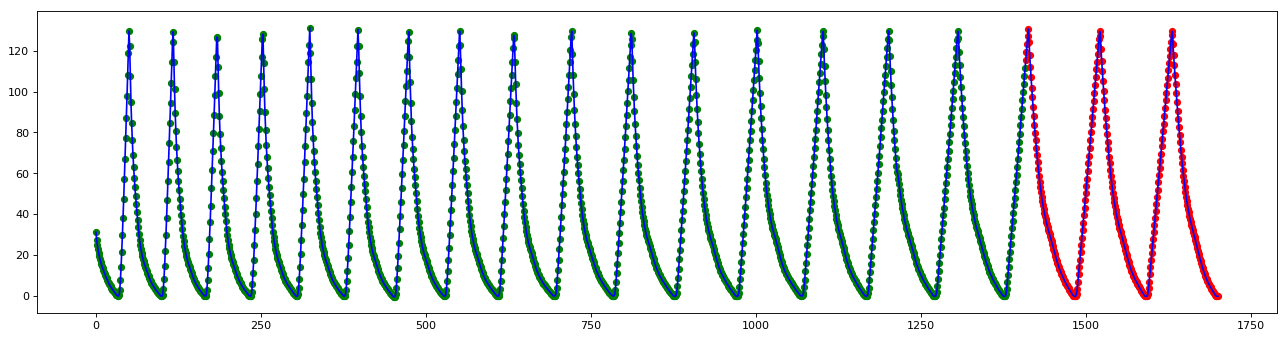

In [47]:
#Set the figure parameters
fig=plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')

#Plot the original data using the defined train and test sizes
train_plot, test_plot = data[:-n_test], data[-n_test:]

#Line plot along the true data
plt.plot(data, color="blue")

#Plot the training points in green
train_plot_x = [x for x in range(len(train_plot))]
plt.scatter(train_plot_x, train_plot, color="green", s=30)

#Note: we have to shift the test data to plot it
test_plot_x = [x +len(train_plot) for x in range(len(test_plot))]
plt.scatter(test_plot_x, test_plot, color="red", s=30)


## Define LSTM architecture

* NOTE: We have to switch the input such that 2nd dimension (time_steps) is representative of how many steps to look into the past.  
* NOTE: "features" is dim 1. It is just representative of the number of dimensions in our input, nothing to do with number of points, nor the number of points on the output.

In [48]:
# fit an LSTM network to training data

def fit_lstm(train, n_prev, n_forecast, n_batch, nb_epoch, n_neurons):
    """
    Function to convert data so it can be interpreted by the LSTM and then trains and returns the LSTM model
    Note: 
    
    Input to every LSTM layer must be 3 dimensional
    - Samples: one sequence is one sample. A batch is comprised of 1 or more samples.
    - Time Steps: One time step is one point of observation in the sample.
    - Features: One feature is one observation at a time step.
    
    """
    
    architecture = ""
    # reshape training into [samples, timesteps, features]
    
    #Split the training data into X (input) and y (labels)
    X, y = train[:, 0:n_prev], train[:, n_prev:]

    print("X shape: " + str(X.shape))
    print("y shape: " + str(y.shape))
    
    #Reshape X so Samples=num_examples, TimeSteps=1, Features = n_lag
    #X = X.reshape(X.shape[0], 1, X.shape[1]) !!!!
    X = X.reshape(X.shape[0],X.shape[1],1)
    
    #y = y.reshape(1, y.shape[0])
    
    #print(y.shape[1])
    
    model = Sequential()
    #We feed in batch sizes of dimension: (n_batch, 1, n_lag)
    print((n_batch, X.shape[1], X.shape[2]))
    print(X.shape)
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    architecture += "LSTM; "
    #model.add(Dense(300))
    #Last layer is a fully connected layer to output size n_forecast
    model.add(Dense(y.shape[1]))
    architecture += "Dense output; "
    #Compile the network
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    
    
    
    #Fit the network to the training data
    for i in range(nb_epoch):
        print(i)
        
        start = timer()
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
        model.reset_states()
        end = timer()
        print("Epoch duration: " + str(end - start))
    return model, architecture

## Train the Neural Network

In [49]:
n_epochs = 100
n_batch = 1
n_neurons = 1
print(len(train))
print(train.shape)
model, architecture = fit_lstm(train, n_prev, n_forecast, n_batch, n_epochs, n_neurons)


1118
(1118, 292)
X shape: (1118, 219)
y shape: (1118, 73)
(1, 219, 1)
(1118, 219, 1)
0
Epoch duration: 261.82682395
1
Epoch duration: 263.029027939
2
Epoch duration: 260.743102074
3
Epoch duration: 262.829834223
4
Epoch duration: 262.58998394
5
Epoch duration: 262.536860943
6
Epoch duration: 264.900299072
7
Epoch duration: 266.004995108
8
Epoch duration: 263.06353116
9
Epoch duration: 263.260046005
10
Epoch duration: 265.26230216
11
Epoch duration: 265.232839108
12
Epoch duration: 266.11936903
13
Epoch duration: 266.911173105
14
Epoch duration: 263.458355904
15
Epoch duration: 262.879401922
16
Epoch duration: 262.659528017
17
Epoch duration: 266.22794199
18
Epoch duration: 262.767022848
19
Epoch duration: 262.605709791
20
Epoch duration: 262.359657049
21
Epoch duration: 264.118896008
22
Epoch duration: 261.827602863
23
Epoch duration: 265.927853107
24
Epoch duration: 263.93568182
25
Epoch duration: 264.896605968
26
Epoch duration: 260.212089062
27
Epoch duration: 262.634562016
28
Epoch

In [50]:
def forecast_lstm(model, X, n_batch):
    
    #Reshape input data to [samples, timesteps, features] for the LSTM
    #X = X.reshape(1,1,len(X))
    #X = X.reshape(n_batch,1,len(X))
    X = X.reshape(n_batch,len(X),1)

    #Make a forecast    
    forecast = model.predict(X, batch_size=n_batch)
    
    #Convert to array
    return [y_hat for y_hat in forecast[0,:]]

In [51]:
#Run on test data
test_x, test_y = test[0:n_prev], test[n_prev:]
test_x = np.array(test_x)
print(len(test_x))
y_hat = forecast_lstm(model, test_x, n_batch)
print("First true label: " + str(test_y[0]))
print("First forecast: " +str(y_hat[0]))

RMSE = []
for i in range(n_forecast):
    RMSE.append(math.sqrt(mean_squared_error(test_y, y_hat)))
print("Average RMSE: ")
print(sum(RMSE)/len(RMSE))

219
First true label: [120.86565]
First forecast: 38.441563
Average RMSE: 
38.5772247642


## Evaluate the forecast based on its RMSE and record results

In [52]:
#Evaluate forecasts and record them in a text file
from sklearn.metrics import mean_squared_error
import math

RMSE = []
for i in range(n_forecast):
    RMSE.append(math.sqrt(mean_squared_error(test_y, y_hat)))
print("RMSE: ")
print(RMSE)

#Open the textfile to append to
text_file = open("results.txt", "a")

text_file.write("\n\nNEW TRIAL: \n\n")
text_file.write("Architecture: " + str(architecture)+"\n")
text_file.write("Epochs: " + str(n_epochs)+"\n")
text_file.write("Average RMSE: " + str(sum(RMSE)/len(RMSE))+"\n")
text_file.write("Average predicted value: " + str(sum(y_hat)/len(y_hat))+"\n")
text_file.write("Variance of predicted values: " + str(np.var(y_hat))+"\n")
text_file.write("Min: " + str(min(y_hat))+ " Max: " +str(max(y_hat)) + "\n")


#Close the file after writing results to it
text_file.close()


RMSE: 
[38.57722476420268, 38.57722476420268, 38.57722476420268, 38.57722476420268, 38.57722476420268, 38.57722476420268, 38.57722476420268, 38.57722476420268, 38.57722476420268, 38.57722476420268, 38.57722476420268, 38.57722476420268, 38.57722476420268, 38.57722476420268, 38.57722476420268, 38.57722476420268, 38.57722476420268, 38.57722476420268, 38.57722476420268, 38.57722476420268, 38.57722476420268, 38.57722476420268, 38.57722476420268, 38.57722476420268, 38.57722476420268, 38.57722476420268, 38.57722476420268, 38.57722476420268, 38.57722476420268, 38.57722476420268, 38.57722476420268, 38.57722476420268, 38.57722476420268, 38.57722476420268, 38.57722476420268, 38.57722476420268, 38.57722476420268, 38.57722476420268, 38.57722476420268, 38.57722476420268, 38.57722476420268, 38.57722476420268, 38.57722476420268, 38.57722476420268, 38.57722476420268, 38.57722476420268, 38.57722476420268, 38.57722476420268, 38.57722476420268, 38.57722476420268, 38.57722476420268, 38.57722476420268, 38.5

## Display Results
* Blue: Sample used for prediction
* Green: What we are trying to predict
* Red: Actual prediction

y size: 73
x size: 73
219
219
Epochs: 100
Average RMSE: 38.5772247642
Average predicted value: 37.93205402322011
Variance of predicted values: 0.39687225
Min: 37.05158 Max: 38.721214


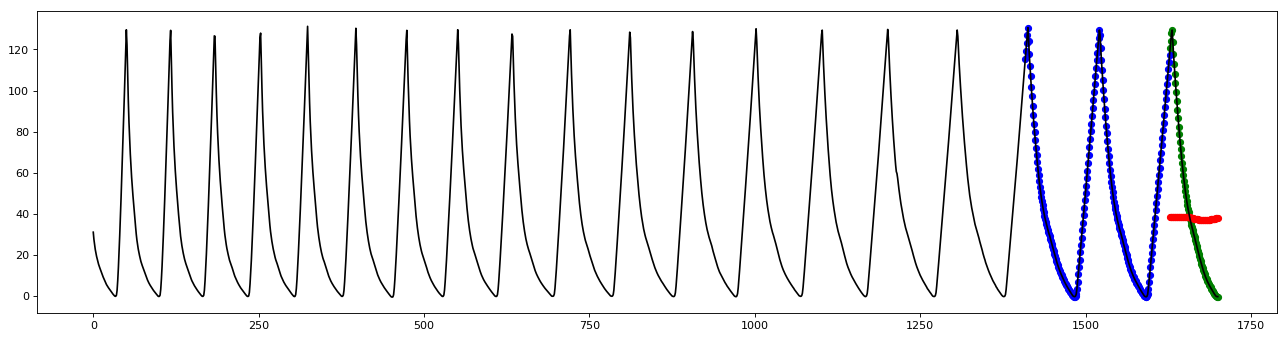

In [53]:
#Display forecasts

#Build a larger figure
fig=plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')

#data = data[:int(len(data)/2)]
plt.plot(data, color="black")



xs = [x for x in range(len(data))]
#plt.scatter(xs, data, color="blue", s = 15)






#Define indices for which to plot the prediction
index_start = len(data) - len(y_hat)
index_end = len(data)
labels_x = [x for x in range(index_start, index_end)]

#print(len(test_y))
#print(len(y_hat))
#print(len(labels_x))
#mod_data = [y+ for y in data[-40:]]
#fake_y = [y for y in range()]



#Display true labels in green
#Display true labels in green
true_labels = [data[y] for y in range(index_start, index_end)]
plt.scatter(labels_x, true_labels, color="green", s=30)

print("y size: " +str(len(y_hat)))
print("x size: " +str(len(labels_x)))


#Display the X of that this prediction was based on
test_x_start = len(data) - n_test
test_x_end = len(data) - len(y_hat)
test_x_indices = [x for x in range(test_x_start, test_x_end)]

test_x_labels = [data[y] for y in test_x_indices]

print(len(test_x_indices))
print(len(test_x_labels))

plt.scatter(test_x_indices, test_x_labels, color="blue", s=30)

#Display forecasted labels in red
index_start = test_x_end
index_end = len(data)
labels_x = [x for x in range(index_start, index_end)]
plt.scatter(labels_x, y_hat, color="red", s=30)

print("Epochs: " + str(n_epochs))
print("Average RMSE: " + str(sum(RMSE)/len(RMSE)))
print("Average predicted value: " + str(sum(y_hat)/len(y_hat)))
print("Variance of predicted values: " + str(np.var(y_hat)))
print("Min: " + str(min(y_hat)) + " Max: "+str(max(y_hat)))